In [1]:
import numpy as np
import glob
import re
#Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

#spacy
import spacy
# python -m spacy download en_core_web_sm
#nltk stopwords
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

#pandas
import pandas as pd

#vis
import pyLDAvis
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()

[nltk_data] Downloading package stopwords to /home/sifr/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/home/sifr/uni/nlp/nlp_project/venv/lib/python3.10/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload


In [7]:
df = pd.read_csv("data/ExtractedTweets.csv")
df.head()

democrats = df.query("Party == 'Democrat'").sample(10000)
republican = df.query("Party == 'Republican'").sample(10000)

df_slim = democrats.append(republican)
df_slim.head()
df = df_slim

/tmp/ipykernel_39632/3638647574.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_slim = democrats.append(republican)


### Extract tweet information

In [8]:
def find_retweeted(tweet):
    '''This function will extract the twitter handles of retweed people'''
    return re.findall('(?<=RT\\s)(@[A-Za-z]+[A-Za-z0-9-_]+)', tweet)

def find_mentioned(tweet):
    '''This function will extract the twitter handles of people mentioned in the tweet'''
    return re.findall('(?<!RT\\s)(@[A-Za-z]+[A-Za-z0-9-_]+)', tweet)

def find_hashtags(tweet):
    '''This function will extract hashtags'''
    return re.findall('(#[A-Za-z]+[A-Za-z0-9-_]+)', tweet)

# make new columns for retweeted usernames, mentioned usernames and hashtags
df['retweeted'] = df['Tweet'].apply(find_retweeted)
df['mentioned'] = df['Tweet'].apply(find_mentioned)
df['hashtags'] = df['Tweet'].apply(find_hashtags)
df.head(30)

print("Extracted tweet metadata")

Extracted tweet metadata


### Clean metioned, retweets and hashtags from tweet

In [9]:
stop_words = stopwords.words('english')
stop_words.append("rt")

def clean_retweeted(tweet):
    '''This function will extract the twitter handles of retweed people'''
    return re.sub('(?<=RT\\s)(@[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet)

def clean_mentioned(tweet):
    '''This function will extract the twitter handles of people mentioned in the tweet'''
    return re.sub('(?<!RT\\s)(@[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet)

def clean_hashtags(tweet):
    '''This function will extract hashtags'''
    return re.sub('(#[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet)

def clean(tweet):
    # Remove mentions, retweets and hashtags
    tweet = clean_hashtags(tweet)
    tweet = clean_mentioned(tweet)
    tweet = clean_retweeted(tweet)
    tweet = tweet.lower()
    # Remove punctuation
    tweet = re.sub("[\\.,;:!/\\?]*", "", tweet)
    # Remove links
    tweet = re.sub(r"http\S+", "", tweet)
    # Remove stop words
    tweet = ' '.join([word for word in tweet.split(' ') if not word in stop_words])
    # Remove multiple spaces
    tweet = re.sub("\\s+", " ", tweet)
    return tweet

df['TweetCleaned'] = df['Tweet'].apply(clean)
df.head()

print("Cleaned tweets")

Cleaned tweets


### Lemmatize the text

In [10]:
import warnings
# Ignore DeprecationWarning from SelectableGroups
warnings.filterwarnings("ignore", category=DeprecationWarning)
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

def lemmatization(tweet, allowed_postags=["NOUN", "ADJ", "VERB", "ADV"]):
    doc = nlp(tweet)
    new_text = []
    for token in doc:
        if token.pos_ in allowed_postags:
            new_text.append(token.lemma_)
    final = " ".join(new_text)
    return final

df['TweetCleaned'] = df['TweetCleaned'].apply(lemmatization)
df.head()
print("Lemmatized tweets")

Lemmatized tweets


In [ ]:
gensim.utils.simple_preprocess("today vote proud support similar legislation", deacc=True)
df.head()

In [11]:
def gen_words(tweet):
    # Use gensims simple simple_preprocess to remove accents, lowercase and tokenize
    return gensim.utils.simple_preprocess(tweet, deacc=True)

df['TweetWords'] = df['TweetCleaned'].apply(gen_words)
df.head()

print("Generated tokens")

Generated tokens


In [12]:
#BIGRAMS AND TRIGRAMS
bigram_phrases = gensim.models.Phrases(df['TweetWords'], min_count=5, threshold=100)
trigram_phrases = gensim.models.Phrases(bigram_phrases[df['TweetWords']], threshold=100)

bigram = gensim.models.phrases.Phraser(bigram_phrases)
trigram = gensim.models.phrases.Phraser(trigram_phrases)

def make_bigrams(tweetWords):
    return bigram[tweetWords]

def make_trigrams(bigrams):
    return trigram[bigram[bigrams]]

df['bigramms'] =  df['TweetWords'].apply(make_bigrams)
df['trigrams'] = df['bigramms'].apply(make_trigrams)
df.head(30)

print("Generated trigrams")

Generated trigrams


In [13]:
#TF-IDF REMOVAL
from gensim.models import TfidfModel

id2word = corpora.Dictionary(df['trigrams'])

texts = df['trigrams']

corpus = [id2word.doc2bow(text) for text in texts]
# print (corpus[0][0:20])

tfidf = TfidfModel(corpus, id2word=id2word)

low_value = 0.03
words  = []
words_missing_in_tfidf = []
for i in range(0, len(corpus)):
    bow = corpus[i]
    low_value_words = [] #reinitialize to be safe. You can skip this.
    tfidf_ids = [id for id, value in tfidf[bow]]
    bow_ids = [id for id, value in bow]
    low_value_words = [id for id, value in tfidf[bow] if value < low_value]
    drops = low_value_words+words_missing_in_tfidf
    for item in drops:
        words.append(id2word[item])
    words_missing_in_tfidf = [id for id in bow_ids if id not in tfidf_ids] # The words with tf-idf socre 0 will be missing

    new_bow = [b for b in bow if b[0] not in low_value_words and b[0] not in words_missing_in_tfidf]
    corpus[i] = new_bow

print("TF-IDF removal")
print("Finish preprocessing")

import pickle


TF-IDF removal
Finish preprocessing


In [ ]:

file = open("data.bin", "wb")
pickle.dump((df, id2word, corpus, tfidf), file)


In [ ]:
import pickle
(df, id2word, corpus, tfidf) = pickle.load(open("data.bin", "rb"))
df.head()
texts = df['trigrams']

In [14]:
lda_model = gensim.models.LdaMulticore(
                corpus=corpus[:-1],
                id2word=id2word,
                num_topics=10,
                random_state=100,
                chunksize=100,
                passes=10
            )


In [ ]:
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word, mds="mmds", R=30)
vis

In [15]:
def get_document_topic(model, tri):
    doc_bow = id2word.doc2bow(tri)
    vec = model.get_document_topics(bow=doc_bow, minimum_probability=0)
    return [v for _, v in vec]

#df['topic_vec'] = df['trigrams'].apply(lambda trigram: get_document_topic(lda_model, trigram))
df.head()

,Party,Handle,Tweet,retweeted,mentioned,hashtags,TweetCleaned,TweetWords,bigramms,trigrams
17807,Democrat,RepSusanDavis,Wonderful to see so much Star Power at the Gir...,[],[],[],wonderful see much star power girl run awesome...,"[wonderful, see, much, star, power, girl, run,...","[wonderful, see, much, star, power, girl, run,...","[wonderful, see, much, star, power, girl, run,..."
9003,Democrat,repmarkpocan,You should vote on the #DREAMAct because it’s ...,[],[],[#DREAMAct],vote ’s right thing hold future young people h,"[vote, right, thing, hold, future, young, people]","[vote, right, thing, hold, future, young, people]","[vote, right, thing, hold, future, young, people]"
8311,Democrat,RepTimWalz,The VA Medicinal Cannabis Research Act of 2018...,[],[],[#bipartisan],pragmatic piece legislation help imp,"[pragmatic, piece, legislation, help, imp]","[pragmatic, piece, legislation, help, imp]","[pragmatic, piece, legislation, help, imp]"
1784,Democrat,RepKihuen,Hoping for a speedy rescue for this pilot and ...,[],[],[],hope speedy rescue pilot hold nelli afb family...,"[hope, speedy, rescue, pilot, hold, nelli, afb...","[hope, speedy, rescue, pilot, hold, nelli, afb...","[hope, speedy, rescue, pilot, hold, nelli, afb..."
16515,Democrat,BettyMcCollum04,While big corporations and @HouseGOP’s wealthy...,[],[@HouseGOP],[#GOPTaxScam],big corporation wealthy donor get huge tax bre...,"[big, corporation, wealthy, donor, get, huge, ...","[big, corporation_wealthy, donor, get, huge, t...","[big, corporation_wealthy, donor, get, huge, t..."


In [16]:
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, confusion_matrix, plot_confusion_matrix
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

def evaluate_model(model):
    df['topic_vec'] = df['trigrams'].apply(lambda trigram: get_document_topic(model, trigram))
    df['len'] = df['topic_vec'].apply(lambda x: len(x))

    result = {}

    text_train, text_test, label_train, label_test = train_test_split(df["topic_vec"], df['Party'], train_size=0.70, random_state=101, test_size=0.30, shuffle=True)
    classifiers = [('MLP', MLPClassifier()), ('G-NB', GaussianNB()), ('L-SVM', LinearSVC())]
    for name, cl in classifiers:

        # Train and predict
        cl.fit(text_train.to_list(), label_train)

        prediction = cl.predict(text_test.to_list())

        # Confusion matrix
        confusion = confusion_matrix(label_test, prediction)
        # increase size of plot and fontsize for improved visibility
        #fig, ax_cm = plt.subplots(figsize=(10, 10))
        #plt.rcParams.update({'font.size': 14})
        # create plot for multi-class confusion matrix, use prepared axes object and change colormap for better contrast
        #plot_confusion_matrix(cl, text_test.to_list(), label_test.to_list(), ax=ax_cm, cmap=plt.cm.Reds_r)
        # show plot corresponding to printed name and accuracy
        #plt.show()
        accuracy = accuracy_score(label_test, prediction)
        precision, recall, fscore, *rest = precision_recall_fscore_support(label_test, prediction, average='macro')
        result[name] = confusion, accuracy, precision, recall, fscore
    return result

Evaluating the model see: https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#5preparestopwords

In [17]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    perplexitiy_values = []
    model_list = []
    evaluations = []
    for num_topics in range(start, limit, step):
        print("Generated model with " + str(num_topics) + " topics")
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=num_topics,
                                           random_state=100,
                                           alpha='auto',
                                           per_word_topics=True)
        model_list.append(model)
        perplexity = model.log_perplexity(corpus)
        print('Perplexity: ', perplexity)  # a measure of how good the model is. lower the better.
        #coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        #coherence_values.append(coherencemodel.get_coherence())
        evaluation = evaluate_model(model)
        evaluations.append(evaluation)
        perplexitiy_values.append(perplexity)
        #print("Coherence: " + str(coherencemodel.get_coherence()))
        print("Evaluation: " + str(evaluation))

    return model_list, perplexitiy_values, evaluations


In [18]:
limit=300
start=2
step=5

model_list, perplexitiy_values, evaluations = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=texts, start=start, limit=limit, step=step)

Generated model with 2 topics
Perplexity:  -7.905141759834616
Evaluation: {'MLP': (array([[1912, 1095],
       [1699, 1294]]), 0.5343333333333333, 0.5355712203966323, 0.5340959078554983, 0.5293401024805495), 'G-NB': (array([[1207, 1800],
       [1039, 1954]]), 0.5268333333333334, 0.528955638177099, 0.5271267032453844, 0.5193836599078194), 'L-SVM': (array([[1336, 1671],
       [1258, 1735]]), 0.5118333333333334, 0.5122149402093725, 0.5119912875081208, 0.5096649491547329)}
Generated model with 7 topics
Perplexity:  -8.310491268764789
Evaluation: {'MLP': (array([[1713, 1294],
       [1345, 1648]]), 0.5601666666666667, 0.560166600049174, 0.5601444385641655, 0.5601150412791501), 'G-NB': (array([[1433, 1574],
       [1118, 1875]]), 0.5513333333333333, 0.552688165199146, 0.5515082248781132, 0.5488852337445911), 'L-SVM': (array([[1696, 1311],
       [1496, 1497]]), 0.5321666666666667, 0.5322239894608316, 0.5320921747240623, 0.5316514702742869)}
Generated model with 12 topics
Perplexity:  -9.39

/home/sifr/uni/nlp/nlp_project/venv/lib64/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Evaluation: {'MLP': (array([[1620, 1387],
       [1302, 1691]]), 0.5518333333333333, 0.5518987502218167, 0.5518639490370558, 0.5517705687621426), 'G-NB': (array([[1482, 1525],
       [1144, 1849]]), 0.5551666666666667, 0.5561853310405136, 0.5553124122564668, 0.5534961344682052), 'L-SVM': (array([[1647, 1360],
       [1399, 1594]]), 0.5401666666666667, 0.5401582194213661, 0.5401489963667581, 0.5401307840936811)}
Generated model with 22 topics
Perplexity:  -11.118587668875396


/home/sifr/uni/nlp/nlp_project/venv/lib64/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Evaluation: {'MLP': (array([[1607, 1400],
       [1287, 1706]]), 0.5521666666666667, 0.5522731490113657, 0.552208173133387, 0.5520447108391926), 'G-NB': (array([[1380, 1627],
       [1114, 1879]]), 0.5431666666666667, 0.544633189249178, 0.543363680535594, 0.5399848826602021), 'L-SVM': (array([[1646, 1361],
       [1411, 1582]]), 0.538, 0.5379915482822633, 0.5379780401026628, 0.5379474286852193)}
Generated model with 27 topics
Perplexity:  -11.811146859272185


/home/sifr/uni/nlp/nlp_project/venv/lib64/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Evaluation: {'MLP': (array([[1667, 1340],
       [1402, 1591]]), 0.543, 0.5429959115038522, 0.542973400632959, 0.5429266651227153), 'G-NB': (array([[1444, 1563],
       [1093, 1900]]), 0.5573333333333333, 0.5589167129828239, 0.5575137020190444, 0.5547616365460233), 'L-SVM': (array([[1738, 1269],
       [1424, 1569]]), 0.5511666666666667, 0.5512531207668228, 0.5511039448992556, 0.5508102970248148)}
Generated model with 32 topics
Perplexity:  -12.546773553856092


/home/sifr/uni/nlp/nlp_project/venv/lib64/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Evaluation: {'MLP': (array([[1604, 1403],
       [1335, 1658]]), 0.5436666666666666, 0.5437084599088134, 0.5436906267600791, 0.5436297006724211), 'G-NB': (array([[1426, 1581],
       [1138, 1855]]), 0.5468333333333333, 0.5480170953054653, 0.5470031447948994, 0.5445047276271452), 'L-SVM': (array([[1702, 1305],
       [1448, 1545]]), 0.5411666666666667, 0.5412113617376775, 0.541108557146589, 0.540852290780985)}
Generated model with 37 topics
Perplexity:  -13.247600662488155


/home/sifr/uni/nlp/nlp_project/venv/lib64/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Evaluation: {'MLP': (array([[1529, 1478],
       [1193, 1800]]), 0.5548333333333333, 0.5554173191212182, 0.554941743571715, 0.5539233245243442), 'G-NB': (array([[1406, 1601],
       [1072, 1921]]), 0.5545, 0.5564108962962657, 0.554703297829066, 0.5511934803003518), 'L-SVM': (array([[1702, 1305],
       [1377, 1616]]), 0.553, 0.5530060345179363, 0.552969566167638, 0.5529081474627399)}
Generated model with 42 topics
Perplexity:  -13.978358826256207


/home/sifr/uni/nlp/nlp_project/venv/lib64/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Evaluation: {'MLP': (array([[1605, 1402],
       [1243, 1750]]), 0.5591666666666667, 0.559378208235898, 0.5592261002309902, 0.5589090573036057), 'G-NB': (array([[1315, 1692],
       [1008, 1985]]), 0.55, 0.5529603048396502, 0.5502635514348911, 0.5443178973365099), 'L-SVM': (array([[1634, 1373],
       [1382, 1611]]), 0.5408333333333334, 0.5408282724486385, 0.5408273333932596, 0.5408265860351115)}
Generated model with 47 topics
Perplexity:  -14.690347077288154


/home/sifr/uni/nlp/nlp_project/venv/lib64/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Evaluation: {'MLP': (array([[1608, 1399],
       [1275, 1718]]), 0.5543333333333333, 0.5544616695326926, 0.5543791293974822, 0.554183489450621), 'G-NB': (array([[1421, 1586],
       [1085, 1908]]), 0.5548333333333333, 0.5565590493519617, 0.5550257440290508, 0.5518811136623943), 'L-SVM': (array([[1702, 1305],
       [1354, 1639]]), 0.5568333333333333, 0.5568313581265649, 0.5568118648645977, 0.5567844688210208)}
Generated model with 52 topics
Perplexity:  -15.442874291832466


/home/sifr/uni/nlp/nlp_project/venv/lib64/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Evaluation: {'MLP': (array([[1544, 1463],
       [1292, 1701]]), 0.5408333333333334, 0.5410196961943159, 0.5408973337743728, 0.5405187290597944), 'G-NB': (array([[1349, 1658],
       [1054, 1939]]), 0.548, 0.5502209671882902, 0.5482324292654482, 0.5435867373127379), 'L-SVM': (array([[1647, 1360],
       [1353, 1640]]), 0.5478333333333333, 0.5478333333333334, 0.5478335937606771, 0.5478327178834215)}
Generated model with 57 topics
Perplexity:  -16.274448065919604


/home/sifr/uni/nlp/nlp_project/venv/lib64/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Evaluation: {'MLP': (array([[1713, 1294],
       [1363, 1630]]), 0.5571666666666667, 0.5571738039879817, 0.557137422192632, 0.5570819093687123), 'G-NB': (array([[1433, 1574],
       [1094, 1899]]), 0.5553333333333333, 0.5569325514218966, 0.5555175800401579, 0.5526347765985287), 'L-SVM': (array([[1643, 1364],
       [1300, 1693]]), 0.556, 0.5560423979723347, 0.5560224716779013, 0.5559691645253142)}
Generated model with 62 topics
Perplexity:  -17.035934224926226


/home/sifr/uni/nlp/nlp_project/venv/lib64/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Evaluation: {'MLP': (array([[1498, 1509],
       [1176, 1817]]), 0.5525, 0.5532556440923959, 0.5526270643029056, 0.5512314684851254), 'G-NB': (array([[1417, 1590],
       [1088, 1905]]), 0.5536666666666666, 0.5553665201785271, 0.5538594599015039, 0.5506944606007027), 'L-SVM': (array([[1689, 1318],
       [1381, 1612]]), 0.5501666666666667, 0.5501667574568376, 0.5501397174273505, 0.5500925694123346)}
Generated model with 67 topics
Perplexity:  -17.98589087863017


/home/sifr/uni/nlp/nlp_project/venv/lib64/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Evaluation: {'MLP': (array([[1716, 1291],
       [1465, 1528]]), 0.5406666666666666, 0.5407445926220993, 0.5405964988031602, 0.5402152602265958), 'G-NB': (array([[1292, 1715],
       [ 999, 1994]]), 0.5476666666666666, 0.5507785455624298, 0.5479426499099829, 0.5413887370886735), 'L-SVM': (array([[1554, 1453],
       [1262, 1731]]), 0.5475, 0.5477511849017817, 0.547571814557657, 0.5471058688823949)}
Generated model with 72 topics
Perplexity:  -18.980719763087457


/home/sifr/uni/nlp/nlp_project/venv/lib64/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Evaluation: {'MLP': (array([[1655, 1352],
       [1286, 1707]]), 0.5603333333333333, 0.5603796312773863, 0.5603566063859681, 0.5603003070008369), 'G-NB': (array([[1441, 1566],
       [1087, 1906]]), 0.5578333333333333, 0.5594894782126816, 0.558017204760337, 0.5551615222262045), 'L-SVM': (array([[1664, 1343],
       [1263, 1730]]), 0.5656666666666667, 0.5657339773739363, 0.5656954132305831, 0.5656141059734895)}
Generated model with 77 topics
Perplexity:  -20.091200238680674


/home/sifr/uni/nlp/nlp_project/venv/lib64/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Evaluation: {'MLP': (array([[1747, 1260],
       [1366, 1627]]), 0.5623333333333334, 0.5623778892519843, 0.5622897280218526, 0.5621581966119781), 'G-NB': (array([[1479, 1528],
       [1146, 1847]]), 0.5543333333333333, 0.5553439153439153, 0.5544794632770779, 0.5526505039401552), 'L-SVM': (array([[1656, 1351],
       [1307, 1686]]), 0.557, 0.5570230627303198, 0.5570146993022518, 0.5569889247231181)}
Generated model with 82 topics
Perplexity:  -21.10606136511144


/home/sifr/uni/nlp/nlp_project/venv/lib64/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Evaluation: {'MLP': (array([[1551, 1456],
       [1154, 1839]]), 0.565, 0.5657504929611045, 0.56511507673764, 0.5639954455064469), 'G-NB': (array([[1392, 1615],
       [1022, 1971]]), 0.5605, 0.5631368837017381, 0.5607282195203063, 0.5563687953141644), 'L-SVM': (array([[1663, 1344],
       [1244, 1749]]), 0.5686666666666667, 0.5687689202657087, 0.5687032073841292, 0.5685780334204217)}
Generated model with 87 topics
Perplexity:  -22.648949434109237


/home/sifr/uni/nlp/nlp_project/venv/lib64/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Evaluation: {'MLP': (array([[1682, 1325],
       [1324, 1669]]), 0.5585, 0.5584979006582693, 0.5584979851556969, 0.5584979273930482), 'G-NB': (array([[1541, 1466],
       [1184, 1809]]), 0.5583333333333333, 0.5589354996848519, 0.5584405959543557, 0.557450397704576), 'L-SVM': (array([[1802, 1205],
       [1437, 1556]]), 0.5596666666666666, 0.5599542384505035, 0.5595740465698091, 0.5589252199614219)}
Generated model with 92 topics
Perplexity:  -24.20710932406246


/home/sifr/uni/nlp/nlp_project/venv/lib64/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Evaluation: {'MLP': (array([[1637, 1370],
       [1270, 1723]]), 0.56, 0.5600939169208277, 0.5600364935320203, 0.5599095858693637), 'G-NB': (array([[1448, 1559],
       [1088, 1905]]), 0.5588333333333333, 0.5604600906302591, 0.5590140990767616, 0.5562590317366435), 'L-SVM': (array([[1699, 1308],
       [1319, 1674]]), 0.5621666666666667, 0.5621619044952285, 0.5621600050933611, 0.5621590652615498)}
Generated model with 97 topics
Perplexity:  -26.381608458400905


/home/sifr/uni/nlp/nlp_project/venv/lib64/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Evaluation: {'MLP': (array([[1710, 1297],
       [1275, 1718]]), 0.5713333333333334, 0.5713409501904214, 0.5713395550709109, 0.5713325712579045), 'G-NB': (array([[1553, 1454],
       [1146, 1847]]), 0.5666666666666667, 0.5674628557998131, 0.5667840858244673, 0.5656237292405732), 'L-SVM': (array([[1753, 1254],
       [1329, 1664]]), 0.5695, 0.569520050313145, 0.5694684893284419, 0.569405257195618)}
Generated model with 102 topics
Perplexity:  -28.663028420270972


/home/sifr/uni/nlp/nlp_project/venv/lib64/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Evaluation: {'MLP': (array([[1747, 1260],
       [1375, 1618]]), 0.5608333333333333, 0.5608865817647763, 0.5607862198360858, 0.5606302346593046), 'G-NB': (array([[1365, 1642],
       [ 992, 2001]]), 0.561, 0.5641992925914026, 0.5612503890298959, 0.5560113434550611), 'L-SVM': (array([[1650, 1357],
       [1271, 1722]]), 0.562, 0.5620737669310463, 0.5620310599468819, 0.5619369189163239)}
Generated model with 107 topics
Perplexity:  -31.234854358401954


/home/sifr/uni/nlp/nlp_project/venv/lib64/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Evaluation: {'MLP': (array([[1751, 1256],
       [1310, 1683]]), 0.5723333333333334, 0.5723395194835554, 0.572310004798915, 0.5722783948693855), 'G-NB': (array([[1327, 1680],
       [1045, 1948]]), 0.5458333333333333, 0.5481892289872102, 0.5460778064236128, 0.5409155054566614), 'L-SVM': (array([[1665, 1342],
       [1262, 1731]]), 0.566, 0.5660675081945743, 0.5660287483787412, 0.565947479645037)}
Generated model with 112 topics
Perplexity:  -36.05987388639533


/home/sifr/uni/nlp/nlp_project/venv/lib64/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Evaluation: {'MLP': (array([[1756, 1251],
       [1315, 1678]]), 0.5723333333333334, 0.572346244157422, 0.5723061158888532, 0.5722610454500143), 'G-NB': (array([[1438, 1569],
       [1119, 1874]]), 0.552, 0.553335277201729, 0.5521725618283921, 0.5496218029514963), 'L-SVM': (array([[1664, 1343],
       [1264, 1729]]), 0.5655, 0.5655657658811475, 0.565528356765498, 0.5654490006118775)}
Generated model with 117 topics
Perplexity:  -40.44125400810101


/home/sifr/uni/nlp/nlp_project/venv/lib64/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Evaluation: {'MLP': (array([[1792, 1215],
       [1383, 1610]]), 0.567, 0.5671604766218382, 0.5669323088536815, 0.5666012249715544), 'G-NB': (array([[1364, 1643],
       [1044, 1949]]), 0.5521666666666667, 0.5545199187563357, 0.5523971741623926, 0.5478685924738714), 'L-SVM': (array([[1773, 1234],
       [1312, 1681]]), 0.5756666666666667, 0.5756943768747689, 0.5756340228963469, 0.575566877723696)}
Generated model with 122 topics
Perplexity:  -45.52950306627054


/home/sifr/uni/nlp/nlp_project/venv/lib64/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Evaluation: {'MLP': (array([[1715, 1292],
       [1278, 1715]]), 0.5716666666666667, 0.5716697790910195, 0.5716697790910195, 0.5716666666666667), 'G-NB': (array([[1564, 1443],
       [1162, 1831]]), 0.5658333333333333, 0.5664945718305276, 0.5659402478969052, 0.5649718688766763), 'L-SVM': (array([[1735, 1272],
       [1318, 1675]]), 0.5683333333333334, 0.5683340500385065, 0.5683130941490682, 0.5682901623495682)}
Generated model with 127 topics
Perplexity:  -54.85649047413461


/home/sifr/uni/nlp/nlp_project/venv/lib64/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Evaluation: {'MLP': (array([[1670, 1337],
       [1290, 1703]]), 0.5621666666666667, 0.5621932788051209, 0.5621825607717198, 0.5621534218076765), 'G-NB': (array([[1528, 1479],
       [1153, 1840]]), 0.5613333333333334, 0.562160220690858, 0.5614577234920501, 0.5601439626082261), 'L-SVM': (array([[1764, 1243],
       [1320, 1673]]), 0.5728333333333333, 0.5728577871718094, 0.5728010630280098, 0.5727350505264835)}
Generated model with 132 topics
Perplexity:  -64.25257871567177


/home/sifr/uni/nlp/nlp_project/venv/lib64/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Evaluation: {'MLP': (array([[1721, 1286],
       [1235, 1758]]), 0.5798333333333333, 0.5798676248579695, 0.5798508791881201, 0.5798173547210725), 'G-NB': (array([[1428, 1579],
       [1059, 1934]]), 0.5603333333333333, 0.5623561907057605, 0.5605331629027759, 0.5571839765729397), 'L-SVM': (array([[1746, 1261],
       [1270, 1723]]), 0.5781666666666667, 0.5781626677381045, 0.5781608699869588, 0.5781604679690988)}
Generated model with 137 topics
Perplexity:  -73.7034874657484


/home/sifr/uni/nlp/nlp_project/venv/lib64/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Evaluation: {'MLP': (array([[1512, 1495],
       [1076, 1917]]), 0.5715, 0.5730377465840175, 0.5716606123744451, 0.5695387107508587), 'G-NB': (array([[1296, 1711],
       [1054, 1939]]), 0.5391666666666667, 0.5413611192072283, 0.5394196590625882, 0.5338126473678216), 'L-SVM': (array([[1671, 1336],
       [1308, 1685]]), 0.5593333333333333, 0.5593444078759859, 0.559341823083259, 0.5593309341350858)}
Generated model with 142 topics
Perplexity:  -88.14301020246654


/home/sifr/uni/nlp/nlp_project/venv/lib64/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Evaluation: {'MLP': (array([[1399, 1608],
       [1073, 1920]]), 0.5531666666666667, 0.5550780992008454, 0.553372290582471, 0.5497719345468146), 'G-NB': (array([[1648, 1359],
       [1332, 1661]]), 0.5515, 0.551510067114094, 0.5515080582105392, 0.5514978945317828), 'L-SVM': (array([[1429, 1578],
       [1096, 1897]]), 0.5543333333333333, 0.5559199373174728, 0.5545183523776963, 0.5516052999784019)}
Generated model with 147 topics
Perplexity:  -106.26649267926805


/home/sifr/uni/nlp/nlp_project/venv/lib64/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Evaluation: {'MLP': (array([[1919, 1088],
       [1635, 1358]]), 0.5461666666666667, 0.5475735653767984, 0.5459514724024609, 0.5421641512176492), 'G-NB': (array([[1792, 1215],
       [1518, 1475]]), 0.5445, 0.5448584328215726, 0.5443796860671797, 0.5432249759613716), 'L-SVM': (array([[1412, 1595],
       [1101, 1892]]), 0.5506666666666666, 0.5522324919880344, 0.5508563324400322, 0.5477724100912507)}
Generated model with 152 topics
Perplexity:  -119.96160668403394


/home/sifr/uni/nlp/nlp_project/venv/lib64/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Evaluation: {'MLP': (array([[1769, 1238],
       [1540, 1453]]), 0.537, 0.5372752868515414, 0.5368800341246303, 0.5357121687311337), 'G-NB': (array([[1890, 1117],
       [1707, 1286]]), 0.5293333333333333, 0.5303011213742066, 0.5291013251072144, 0.5245148727168072), 'L-SVM': (array([[1411, 1596],
       [1093, 1900]]), 0.5518333333333333, 0.5534883317127379, 0.552026505477641, 0.5488365931944794)}
Generated model with 157 topics
Perplexity:  -141.76490525236704


/home/sifr/uni/nlp/nlp_project/venv/lib64/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Evaluation: {'MLP': (array([[1440, 1567],
       [1184, 1809]]), 0.5415, 0.5423108600161831, 0.5416464489639999, 0.539759254440106), 'G-NB': (array([[2119,  888],
       [1969, 1024]]), 0.5238333333333334, 0.5269556166021174, 0.5234103496785705, 0.5074275936234545), 'L-SVM': (array([[1236, 1771],
       [ 990, 2003]]), 0.5398333333333334, 0.54299634183097, 0.5401345518436711, 0.5321886592828006)}
Generated model with 162 topics
Perplexity:  -183.46507572319965
Evaluation: {'MLP': (array([[2169,  838],
       [1990, 1003]]), 0.5286666666666666, 0.5331660989517834, 0.5282160980654228, 0.510167941265418), 'G-NB': (array([[1586, 1421],
       [1510, 1483]]), 0.5115, 0.511474416469131, 0.5114627290748583, 0.5113559993276907), 'L-SVM': (array([[1899, 1108],
       [1743, 1250]]), 0.5248333333333334, 0.525763533444281, 0.5245838005118029, 0.5192080542122852)}
Generated model with 167 topics
Perplexity:  -190.03477326334362
Evaluation: {'MLP': (array([[2213,  794],
       [2016,  977]]), 0.531

/home/sifr/uni/nlp/nlp_project/venv/lib64/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sifr/uni/nlp/nlp_project/venv/lib64/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sifr/uni/nlp/nlp_project/venv/lib64/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

Evaluation: {'MLP': (array([[3007,    0],
       [2993,    0]]), 0.5011666666666666, 0.2505833333333333, 0.5, 0.33385144887309864), 'G-NB': (array([[   0, 3007],
       [   0, 2993]]), 0.49883333333333335, 0.24941666666666668, 0.5, 0.3328144112087179), 'L-SVM': (array([[   0, 3007],
       [   0, 2993]]), 0.49883333333333335, 0.24941666666666668, 0.5, 0.3328144112087179)}
Generated model with 197 topics
Perplexity:  -393.3426208496094


/home/sifr/uni/nlp/nlp_project/venv/lib64/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sifr/uni/nlp/nlp_project/venv/lib64/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sifr/uni/nlp/nlp_project/venv/lib64/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

Evaluation: {'MLP': (array([[   0, 3007],
       [   0, 2993]]), 0.49883333333333335, 0.24941666666666668, 0.5, 0.3328144112087179), 'G-NB': (array([[   0, 3007],
       [   0, 2993]]), 0.49883333333333335, 0.24941666666666668, 0.5, 0.3328144112087179), 'L-SVM': (array([[   0, 3007],
       [   0, 2993]]), 0.49883333333333335, 0.24941666666666668, 0.5, 0.3328144112087179)}
Generated model with 202 topics
Perplexity:  -403.2926330566406


/home/sifr/uni/nlp/nlp_project/venv/lib64/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sifr/uni/nlp/nlp_project/venv/lib64/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sifr/uni/nlp/nlp_project/venv/lib64/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

Evaluation: {'MLP': (array([[   0, 3007],
       [   0, 2993]]), 0.49883333333333335, 0.24941666666666668, 0.5, 0.3328144112087179), 'G-NB': (array([[   0, 3007],
       [   0, 2993]]), 0.49883333333333335, 0.24941666666666668, 0.5, 0.3328144112087179), 'L-SVM': (array([[   0, 3007],
       [   0, 2993]]), 0.49883333333333335, 0.24941666666666668, 0.5, 0.3328144112087179)}
Generated model with 207 topics
Perplexity:  -413.2434997558594


/home/sifr/uni/nlp/nlp_project/venv/lib64/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sifr/uni/nlp/nlp_project/venv/lib64/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sifr/uni/nlp/nlp_project/venv/lib64/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

Evaluation: {'MLP': (array([[3007,    0],
       [2993,    0]]), 0.5011666666666666, 0.2505833333333333, 0.5, 0.33385144887309864), 'G-NB': (array([[   0, 3007],
       [   0, 2993]]), 0.49883333333333335, 0.24941666666666668, 0.5, 0.3328144112087179), 'L-SVM': (array([[   0, 3007],
       [   0, 2993]]), 0.49883333333333335, 0.24941666666666668, 0.5, 0.3328144112087179)}
Generated model with 212 topics
Perplexity:  -423.1960754394531


/home/sifr/uni/nlp/nlp_project/venv/lib64/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sifr/uni/nlp/nlp_project/venv/lib64/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sifr/uni/nlp/nlp_project/venv/lib64/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

Evaluation: {'MLP': (array([[3007,    0],
       [2993,    0]]), 0.5011666666666666, 0.2505833333333333, 0.5, 0.33385144887309864), 'G-NB': (array([[   0, 3007],
       [   0, 2993]]), 0.49883333333333335, 0.24941666666666668, 0.5, 0.3328144112087179), 'L-SVM': (array([[   0, 3007],
       [   0, 2993]]), 0.49883333333333335, 0.24941666666666668, 0.5, 0.3328144112087179)}
Generated model with 217 topics
Perplexity:  -433.1492614746094


/home/sifr/uni/nlp/nlp_project/venv/lib64/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sifr/uni/nlp/nlp_project/venv/lib64/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sifr/uni/nlp/nlp_project/venv/lib64/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

Evaluation: {'MLP': (array([[   0, 3007],
       [   0, 2993]]), 0.49883333333333335, 0.24941666666666668, 0.5, 0.3328144112087179), 'G-NB': (array([[   0, 3007],
       [   0, 2993]]), 0.49883333333333335, 0.24941666666666668, 0.5, 0.3328144112087179), 'L-SVM': (array([[   0, 3007],
       [   0, 2993]]), 0.49883333333333335, 0.24941666666666668, 0.5, 0.3328144112087179)}
Generated model with 222 topics
Perplexity:  -443.103759765625


/home/sifr/uni/nlp/nlp_project/venv/lib64/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sifr/uni/nlp/nlp_project/venv/lib64/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sifr/uni/nlp/nlp_project/venv/lib64/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

Evaluation: {'MLP': (array([[3007,    0],
       [2993,    0]]), 0.5011666666666666, 0.2505833333333333, 0.5, 0.33385144887309864), 'G-NB': (array([[3007,    0],
       [2993,    0]]), 0.5011666666666666, 0.2505833333333333, 0.5, 0.33385144887309864), 'L-SVM': (array([[   0, 3007],
       [   0, 2993]]), 0.49883333333333335, 0.24941666666666668, 0.5, 0.3328144112087179)}
Generated model with 227 topics
Perplexity:  -453.0592346191406


/home/sifr/uni/nlp/nlp_project/venv/lib64/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sifr/uni/nlp/nlp_project/venv/lib64/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sifr/uni/nlp/nlp_project/venv/lib64/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

Evaluation: {'MLP': (array([[3007,    0],
       [2993,    0]]), 0.5011666666666666, 0.2505833333333333, 0.5, 0.33385144887309864), 'G-NB': (array([[3007,    0],
       [2993,    0]]), 0.5011666666666666, 0.2505833333333333, 0.5, 0.33385144887309864), 'L-SVM': (array([[   0, 3007],
       [   0, 2993]]), 0.49883333333333335, 0.24941666666666668, 0.5, 0.3328144112087179)}
Generated model with 232 topics
Perplexity:  -463.0155334472656


/home/sifr/uni/nlp/nlp_project/venv/lib64/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sifr/uni/nlp/nlp_project/venv/lib64/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sifr/uni/nlp/nlp_project/venv/lib64/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

Evaluation: {'MLP': (array([[3007,    0],
       [2993,    0]]), 0.5011666666666666, 0.2505833333333333, 0.5, 0.33385144887309864), 'G-NB': (array([[   0, 3007],
       [   0, 2993]]), 0.49883333333333335, 0.24941666666666668, 0.5, 0.3328144112087179), 'L-SVM': (array([[   0, 3007],
       [   0, 2993]]), 0.49883333333333335, 0.24941666666666668, 0.5, 0.3328144112087179)}
Generated model with 237 topics
Perplexity:  -472.9727478027344


/home/sifr/uni/nlp/nlp_project/venv/lib64/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sifr/uni/nlp/nlp_project/venv/lib64/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sifr/uni/nlp/nlp_project/venv/lib64/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

Evaluation: {'MLP': (array([[3007,    0],
       [2993,    0]]), 0.5011666666666666, 0.2505833333333333, 0.5, 0.33385144887309864), 'G-NB': (array([[3007,    0],
       [2993,    0]]), 0.5011666666666666, 0.2505833333333333, 0.5, 0.33385144887309864), 'L-SVM': (array([[   0, 3007],
       [   0, 2993]]), 0.49883333333333335, 0.24941666666666668, 0.5, 0.3328144112087179)}
Generated model with 242 topics
Perplexity:  -482.93072509765625


/home/sifr/uni/nlp/nlp_project/venv/lib64/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sifr/uni/nlp/nlp_project/venv/lib64/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sifr/uni/nlp/nlp_project/venv/lib64/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

Evaluation: {'MLP': (array([[   0, 3007],
       [   0, 2993]]), 0.49883333333333335, 0.24941666666666668, 0.5, 0.3328144112087179), 'G-NB': (array([[3007,    0],
       [2993,    0]]), 0.5011666666666666, 0.2505833333333333, 0.5, 0.33385144887309864), 'L-SVM': (array([[   0, 3007],
       [   0, 2993]]), 0.49883333333333335, 0.24941666666666668, 0.5, 0.3328144112087179)}
Generated model with 247 topics
Perplexity:  -492.889892578125


/home/sifr/uni/nlp/nlp_project/venv/lib64/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sifr/uni/nlp/nlp_project/venv/lib64/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sifr/uni/nlp/nlp_project/venv/lib64/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

Evaluation: {'MLP': (array([[   0, 3007],
       [   0, 2993]]), 0.49883333333333335, 0.24941666666666668, 0.5, 0.3328144112087179), 'G-NB': (array([[3007,    0],
       [2993,    0]]), 0.5011666666666666, 0.2505833333333333, 0.5, 0.33385144887309864), 'L-SVM': (array([[   0, 3007],
       [   0, 2993]]), 0.49883333333333335, 0.24941666666666668, 0.5, 0.3328144112087179)}
Generated model with 252 topics
Perplexity:  -502.8497314453125


/home/sifr/uni/nlp/nlp_project/venv/lib64/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sifr/uni/nlp/nlp_project/venv/lib64/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sifr/uni/nlp/nlp_project/venv/lib64/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

Evaluation: {'MLP': (array([[   0, 3007],
       [   0, 2993]]), 0.49883333333333335, 0.24941666666666668, 0.5, 0.3328144112087179), 'G-NB': (array([[3007,    0],
       [2993,    0]]), 0.5011666666666666, 0.2505833333333333, 0.5, 0.33385144887309864), 'L-SVM': (array([[   0, 3007],
       [   0, 2993]]), 0.49883333333333335, 0.24941666666666668, 0.5, 0.3328144112087179)}
Generated model with 257 topics
Perplexity:  -512.810546875


/home/sifr/uni/nlp/nlp_project/venv/lib64/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sifr/uni/nlp/nlp_project/venv/lib64/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sifr/uni/nlp/nlp_project/venv/lib64/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

Evaluation: {'MLP': (array([[3007,    0],
       [2993,    0]]), 0.5011666666666666, 0.2505833333333333, 0.5, 0.33385144887309864), 'G-NB': (array([[   0, 3007],
       [   0, 2993]]), 0.49883333333333335, 0.24941666666666668, 0.5, 0.3328144112087179), 'L-SVM': (array([[   0, 3007],
       [   0, 2993]]), 0.49883333333333335, 0.24941666666666668, 0.5, 0.3328144112087179)}
Generated model with 262 topics
Perplexity:  -522.7719116210938


/home/sifr/uni/nlp/nlp_project/venv/lib64/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sifr/uni/nlp/nlp_project/venv/lib64/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sifr/uni/nlp/nlp_project/venv/lib64/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

Evaluation: {'MLP': (array([[3007,    0],
       [2993,    0]]), 0.5011666666666666, 0.2505833333333333, 0.5, 0.33385144887309864), 'G-NB': (array([[   0, 3007],
       [   0, 2993]]), 0.49883333333333335, 0.24941666666666668, 0.5, 0.3328144112087179), 'L-SVM': (array([[   0, 3007],
       [   0, 2993]]), 0.49883333333333335, 0.24941666666666668, 0.5, 0.3328144112087179)}
Generated model with 267 topics
Perplexity:  -532.7340087890625


/home/sifr/uni/nlp/nlp_project/venv/lib64/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sifr/uni/nlp/nlp_project/venv/lib64/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sifr/uni/nlp/nlp_project/venv/lib64/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

Evaluation: {'MLP': (array([[   0, 3007],
       [   0, 2993]]), 0.49883333333333335, 0.24941666666666668, 0.5, 0.3328144112087179), 'G-NB': (array([[3007,    0],
       [2993,    0]]), 0.5011666666666666, 0.2505833333333333, 0.5, 0.33385144887309864), 'L-SVM': (array([[   0, 3007],
       [   0, 2993]]), 0.49883333333333335, 0.24941666666666668, 0.5, 0.3328144112087179)}
Generated model with 272 topics
Perplexity:  -542.6968383789062


/home/sifr/uni/nlp/nlp_project/venv/lib64/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sifr/uni/nlp/nlp_project/venv/lib64/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sifr/uni/nlp/nlp_project/venv/lib64/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

Evaluation: {'MLP': (array([[3007,    0],
       [2993,    0]]), 0.5011666666666666, 0.2505833333333333, 0.5, 0.33385144887309864), 'G-NB': (array([[3007,    0],
       [2993,    0]]), 0.5011666666666666, 0.2505833333333333, 0.5, 0.33385144887309864), 'L-SVM': (array([[   0, 3007],
       [   0, 2993]]), 0.49883333333333335, 0.24941666666666668, 0.5, 0.3328144112087179)}
Generated model with 277 topics
Perplexity:  -552.6600952148438


/home/sifr/uni/nlp/nlp_project/venv/lib64/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sifr/uni/nlp/nlp_project/venv/lib64/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sifr/uni/nlp/nlp_project/venv/lib64/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

Evaluation: {'MLP': (array([[3007,    0],
       [2993,    0]]), 0.5011666666666666, 0.2505833333333333, 0.5, 0.33385144887309864), 'G-NB': (array([[3007,    0],
       [2993,    0]]), 0.5011666666666666, 0.2505833333333333, 0.5, 0.33385144887309864), 'L-SVM': (array([[   0, 3007],
       [   0, 2993]]), 0.49883333333333335, 0.24941666666666668, 0.5, 0.3328144112087179)}
Generated model with 282 topics
Perplexity:  -562.624267578125


/home/sifr/uni/nlp/nlp_project/venv/lib64/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sifr/uni/nlp/nlp_project/venv/lib64/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sifr/uni/nlp/nlp_project/venv/lib64/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

Evaluation: {'MLP': (array([[3007,    0],
       [2993,    0]]), 0.5011666666666666, 0.2505833333333333, 0.5, 0.33385144887309864), 'G-NB': (array([[3007,    0],
       [2993,    0]]), 0.5011666666666666, 0.2505833333333333, 0.5, 0.33385144887309864), 'L-SVM': (array([[   0, 3007],
       [   0, 2993]]), 0.49883333333333335, 0.24941666666666668, 0.5, 0.3328144112087179)}
Generated model with 287 topics
Perplexity:  -572.5889282226562


/home/sifr/uni/nlp/nlp_project/venv/lib64/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sifr/uni/nlp/nlp_project/venv/lib64/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sifr/uni/nlp/nlp_project/venv/lib64/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

Evaluation: {'MLP': (array([[   0, 3007],
       [   0, 2993]]), 0.49883333333333335, 0.24941666666666668, 0.5, 0.3328144112087179), 'G-NB': (array([[3007,    0],
       [2993,    0]]), 0.5011666666666666, 0.2505833333333333, 0.5, 0.33385144887309864), 'L-SVM': (array([[   0, 3007],
       [   0, 2993]]), 0.49883333333333335, 0.24941666666666668, 0.5, 0.3328144112087179)}
Generated model with 292 topics
Perplexity:  -582.554443359375


/home/sifr/uni/nlp/nlp_project/venv/lib64/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sifr/uni/nlp/nlp_project/venv/lib64/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sifr/uni/nlp/nlp_project/venv/lib64/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

Evaluation: {'MLP': (array([[   0, 3007],
       [   0, 2993]]), 0.49883333333333335, 0.24941666666666668, 0.5, 0.3328144112087179), 'G-NB': (array([[3007,    0],
       [2993,    0]]), 0.5011666666666666, 0.2505833333333333, 0.5, 0.33385144887309864), 'L-SVM': (array([[   0, 3007],
       [   0, 2993]]), 0.49883333333333335, 0.24941666666666668, 0.5, 0.3328144112087179)}
Generated model with 297 topics
Perplexity:  -592.5201416015625


/home/sifr/uni/nlp/nlp_project/venv/lib64/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sifr/uni/nlp/nlp_project/venv/lib64/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evaluation: {'MLP': (array([[   0, 3007],
       [   0, 2993]]), 0.49883333333333335, 0.24941666666666668, 0.5, 0.3328144112087179), 'G-NB': (array([[3007,    0],
       [2993,    0]]), 0.5011666666666666, 0.2505833333333333, 0.5, 0.33385144887309864), 'L-SVM': (array([[   0, 3007],
       [   0, 2993]]), 0.49883333333333335, 0.24941666666666668, 0.5, 0.3328144112087179)}


/home/sifr/uni/nlp/nlp_project/venv/lib64/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


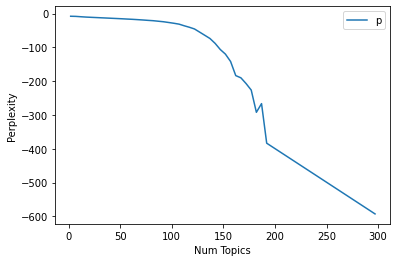

In [24]:
# Create Perplexity Plot for topic numbers

import matplotlib.pyplot as plt
x = range(start, limit, step)
plt.plot(x, perplexitiy_values)
plt.xlabel("Num Topics")
plt.ylabel("Perplexity")
plt.legend("perplexitiy_values", loc='best')
plt.savefig("img/topic_count.pdf")
plt.show()

{'MLP': [0.5343333333333333], 'G-NB': [0.5268333333333334], 'L-SVM': [0.5118333333333334]}
{'MLP': [0.5343333333333333, 0.5601666666666667], 'G-NB': [0.5268333333333334, 0.5513333333333333], 'L-SVM': [0.5118333333333334, 0.5321666666666667]}
{'MLP': [0.5343333333333333, 0.5601666666666667, 0.5406666666666666], 'G-NB': [0.5268333333333334, 0.5513333333333333, 0.5448333333333333], 'L-SVM': [0.5118333333333334, 0.5321666666666667, 0.525]}
{'MLP': [0.5343333333333333, 0.5601666666666667, 0.5406666666666666, 0.5518333333333333], 'G-NB': [0.5268333333333334, 0.5513333333333333, 0.5448333333333333, 0.5551666666666667], 'L-SVM': [0.5118333333333334, 0.5321666666666667, 0.525, 0.5401666666666667]}
{'MLP': [0.5343333333333333, 0.5601666666666667, 0.5406666666666666, 0.5518333333333333, 0.5521666666666667], 'G-NB': [0.5268333333333334, 0.5513333333333333, 0.5448333333333333, 0.5551666666666667, 0.5431666666666667], 'L-SVM': [0.5118333333333334, 0.5321666666666667, 0.525, 0.5401666666666667, 0.538

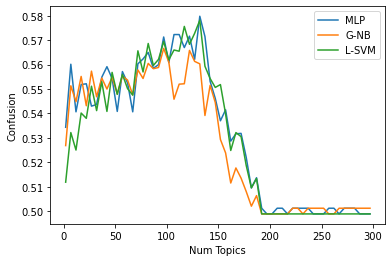

In [29]:
# Create classifier comparision for multiple scores
# Hint: You need to change the respective variables in line 9 and the figure labels
scores = {name: [] for name in evaluations[0].keys()}
for evaluation in evaluations:
    for name, ev in evaluation.items():
    # evaluation: confusion, accuracy, precision, recall, fscore
        confusion, accuracy, precision, recall, fscore = ev

        scores[name].append(accuracy)
    print(scores)
for label, score in scores.items():
    plt.plot(x, score, label = label)
plt.xlabel("Num Topics")
plt.ylabel("Confusion")
plt.legend()
plt.savefig("img/topic_confusion.pdf")
plt.show()

In [21]:
# Create a summary for each classifier

names = evaluations[0].keys()
x = range(0, 200, 5)
print(x)
plt.clf()

# Create summary figure for all classifiers separately
for name in names:
    f1 = []
    acc = []
    pre = []
    rec = []
    evs = []

    for evaluation in evaluations:
        for inner_name, ev in evaluation.items():
            if inner_name == name:
                evs.append(ev)
    for ev in evs[:40]:
    # evaluation: confusion, accuracy, precision, recall, fscore
        confusion, accuracy, precision, recall, fscore = ev

        f1.append(fscore)
        acc.append(accuracy)
        pre.append(precision)
        rec.append(recall)
    plt.plot(x, f1, label = 'F1')
    plt.plot(x, acc, label = 'Accuracy')
    plt.plot(x, pre, label = 'Precision')
    plt.plot(x, rec, label = 'Recall')
    plt.xlabel("Num Topics")
    plt.ylabel("")
    plt.legend()
    plt.savefig("img/summary_" + name.lower() + ".pdf")
    plt.clf()

range(0, 200, 5)


<Figure size 432x288 with 0 Axes>

In [30]:
# Figures show 130 topics are the sweet spot
lda_model = gensim.models.LdaMulticore(
                corpus=corpus[:-1],
                id2word=id2word,
                num_topics=130,
                random_state=100,
                chunksize=100,
                passes=10
            )

Training classifier
Confusion: [[1712 1295]
 [1314 1679]]
Accuracy: 0.5651666666666667
Precision: 0.5651614499044595
Recall: 0.5651569102987339
F1Score: 0.5651535125604217


/home/sifr/uni/nlp/nlp_project/venv/lib64/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


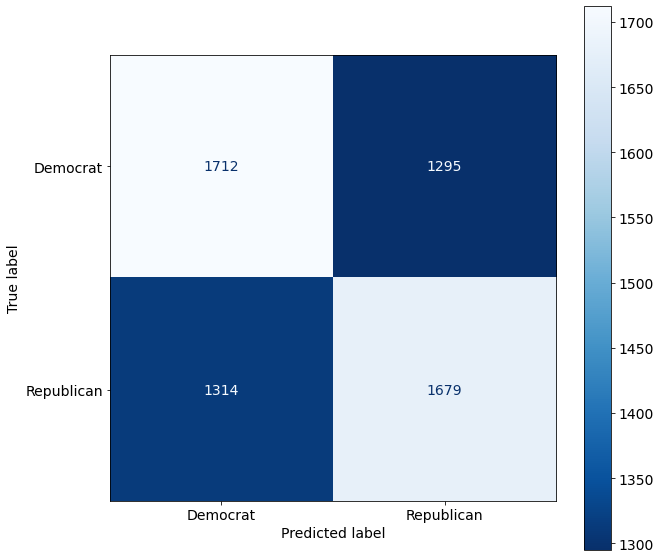

In [37]:
# Rerun the classifier on the new dataset

df['topic_vec'] = df['trigrams'].apply(lambda trigram: get_document_topic(lda_model, trigram))
df['len'] = df['topic_vec'].apply(lambda x: len(x))

print('Training classifier')
text_train, text_test, label_train, label_test = train_test_split(df["topic_vec"], df['Party'], train_size=0.70, random_state=101, test_size=0.30, shuffle=True)
cl = LinearSVC()
# Train and predict
cl.fit(text_train.to_list(), label_train)
prediction = cl.predict(text_test.to_list())
# Confusion matrix
confusion = confusion_matrix(label_test, prediction)
accuracy = accuracy_score(label_test, prediction)
precision, recall, fscore, *rest = precision_recall_fscore_support(label_test, prediction, average='macro')

print("Confusion: " + str(confusion))
print("Accuracy: " + str(accuracy))
print("Precision: " + str(precision))
print("Recall: " + str(recall))
print("F1Score: " + str(fscore))
# increase size of plot and fontsize for improved visibility
fig, ax_cm = plt.subplots(figsize=(10, 10))
plt.rcParams.update({'font.size': 14})
# create plot for multi-class confusion matrix, use prepared axes object and change colormap for better contrast
plot_confusion_matrix(cl, text_test.to_list(), label_test.to_list(), ax=ax_cm, cmap=plt.cm.Blues_r)
# show plot corresponding to printed name and accuracy
plt.savefig("img/lvm_summary_130.pdf")
plt.show()